# Machine Learning Foundations
## Assignment 1

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import VarianceThreshold
from sklearn.metrics import roc_curve, auc
from imblearn.over_sampling import ADASYN
from boruta import BorutaPy

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


## Task 1: Data Loading and Initial Exploration

In [2]:
df = pd.read_excel("titanic3.xls")
df.head()

,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
0,1,1,"Allen, Miss. Elisabeth Walton",female,29.0000,0,0,24160,211.3375,B5,S,2,NaN,"St Louis, MO"
1,1,1,"Allison, Master. Hudson Trevor",male,0.9167,1,2,113781,151.5500,C22 C26,S,11,NaN,"Montreal, PQ / Chesterville, ON"
2,1,0,"Allison, Miss. Helen Loraine",female,2.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"
3,1,0,"Allison, Mr. Hudson Joshua Creighton",male,30.0000,1,2,113781,151.5500,C22 C26,S,NaN,135.0,"Montreal, PQ / Chesterville, ON"
4,1,0,"Allison, Mrs. Hudson J C (Bessie Waldo Daniels)",female,25.0000,1,2,113781,151.5500,C22 C26,S,NaN,NaN,"Montreal, PQ / Chesterville, ON"


At first look, it might be best to exclude boat and body because of leakage. Only the people that survived have a boat number assigned which can lead to a misleading model. Moreover, only the bodies of the people that didnt survive and were recovered have a body number.

In [3]:
df.describe()

,pclass,survived,age,sibsp,parch,fare,body
count,1309.000000,1309.000000,1046.000000,1309.000000,1309.000000,1308.000000,121.000000
mean,2.294882,0.381971,29.881135,0.498854,0.385027,33.295479,160.809917
std,0.837836,0.486055,14.413500,1.041658,0.865560,51.758668,97.696922
min,1.000000,0.000000,0.166700,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,21.000000,0.000000,0.000000,7.895800,72.000000
50%,3.000000,0.000000,28.000000,0.000000,0.000000,14.454200,155.000000
75%,3.000000,1.000000,39.000000,1.000000,0.000000,31.275000,256.000000
max,3.000000,1.000000,80.000000,8.000000,9.000000,512.329200,328.000000


I also looked at correlation plots to try to identify patterns. Survival has non-linear relationships with the features.

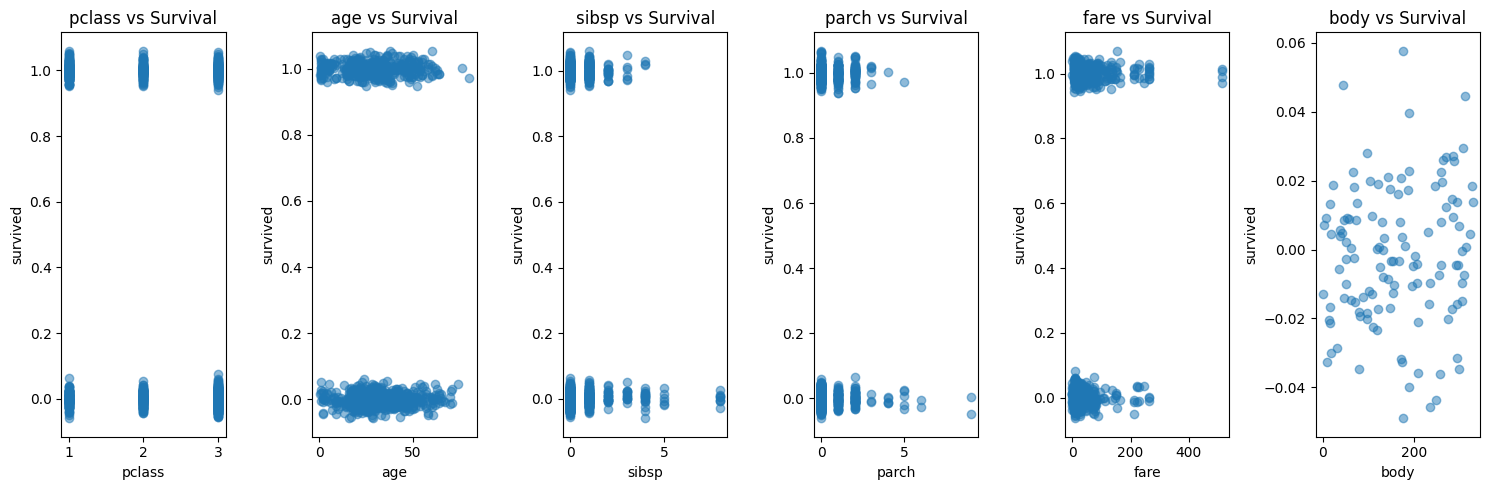

In [4]:
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
numeric_cols = [col for col in numeric_cols if col != 'survived']

plt.figure(figsize=(15, 5))

for i, feature in enumerate(numeric_cols, 1):
    plt.subplot(1, len(numeric_cols), i)
    jitter = np.random.normal(0, 0.02, size=len(df))
    plt.scatter(df[feature], df['survived'] + jitter, alpha=0.5)
    plt.xlabel(feature)
    plt.ylabel('survived')
    plt.title(f'{feature} vs Survival')

plt.tight_layout()
plt.show()

I also checked for potential outliers. fare outlier could be removed later on.

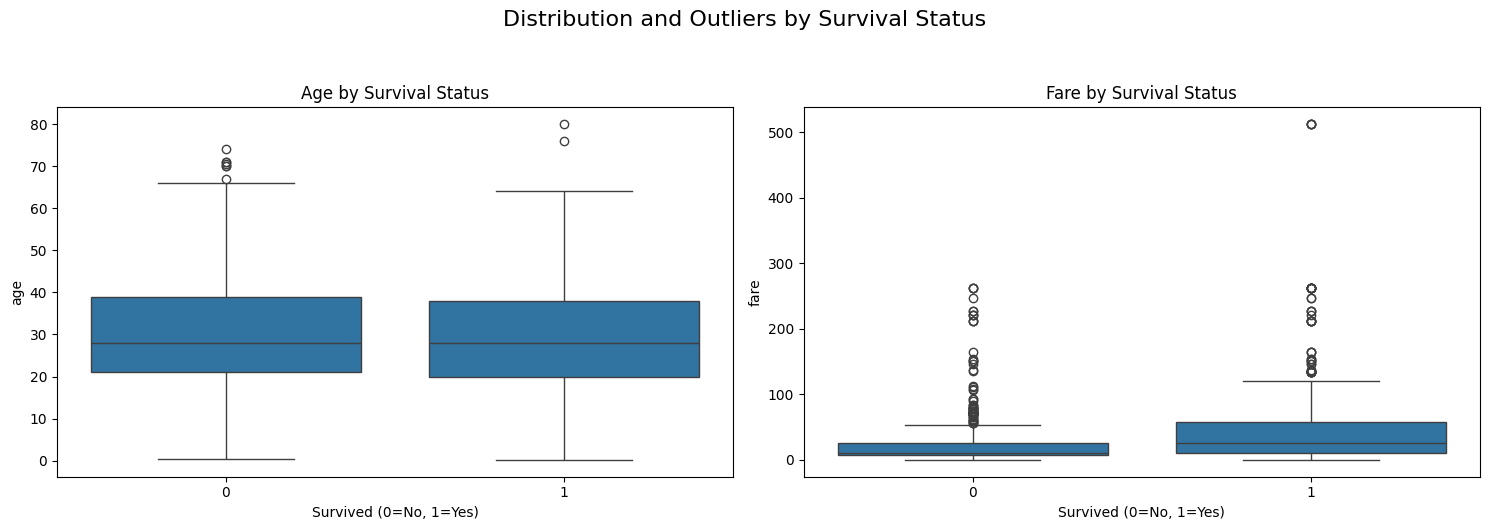

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Distribution and Outliers by Survival Status', fontsize=16, y=1.05)

sns.boxplot(x='survived', y='age', data=df, ax=axes[0])
axes[0].set_title('Age by Survival Status')
axes[0].set_xlabel('Survived (0=No, 1=Yes)')

sns.boxplot(x='survived', y='fare', data=df, ax=axes[1])
axes[1].set_title('Fare by Survival Status')
axes[1].set_xlabel('Survived (0=No, 1=Yes)')

plt.tight_layout()
plt.show()

## Task 2: Managing Missing Values

Depending on the method, we can impute the missing values before or after the split.

In [6]:
df.info()
df.isnull().sum().sort_values(ascending=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pclass     1309 non-null   int64  
 1   survived   1309 non-null   int64  
 2   name       1309 non-null   object 
 3   sex        1309 non-null   object 
 4   age        1046 non-null   float64
 5   sibsp      1309 non-null   int64  
 6   parch      1309 non-null   int64  
 7   ticket     1309 non-null   object 
 8   fare       1308 non-null   float64
 9   cabin      295 non-null    object 
 10  embarked   1307 non-null   object 
 11  boat       486 non-null    object 
 12  body       121 non-null    float64
 13  home.dest  745 non-null    object 
dtypes: float64(3), int64(4), object(7)
memory usage: 143.3+ KB


body         1188
cabin        1014
boat          823
home.dest     564
age           263
embarked        2
fare            1
pclass          0
survived        0
name            0
sex             0
sibsp           0
parch           0
ticket          0
dtype: int64

I started by checking for possible sparse within classes (the ones with a lot of missing data)
In our case, body, cabin, boat, home destination, and age might cause issues.

Here is how i dealt with the missing values:

For the following features, I will be dealing with the missing values before data splitting because I am filling them with a constant. This doesnt use information from the dataset therefore wont cause leakage.


### Boat and Body missing values

My first step was to drop the body and boat columns because they could cause data leakage.

Body is only available for non survivors, Boat is only available for survivors.
This is the case where the target is a function of a feature, they have a direct relationship with survival that can be learned by the model. When using the model in production, we won't know the boat or body number, so the model will perform poorly.

In [7]:
df.drop(columns = ['body', 'boat'], inplace=True)
df.isnull().sum().sort_values(ascending=False)

cabin        1014
home.dest     564
age           263
embarked        2
fare            1
pclass          0
survived        0
name            0
sex             0
sibsp           0
parch           0
ticket          0
dtype: int64

### Home.dest missing values

Since Home.dest is a categorical variable, I replaced the missing values by 'U' for unknown. (however, I might drop the column later on for high missingness)

In [8]:
df['home.dest']= df['home.dest'].fillna('U')
df.isnull().sum().sort_values(ascending=False)

cabin        1014
age           263
embarked        2
fare            1
pclass          0
survived        0
name            0
sex             0
sibsp           0
parch           0
ticket          0
home.dest       0
dtype: int64

### Cabin missing values

I decided to create a new category to store only the letter since deck level might influence evacuation priority. This will simplify the feature since the letter is more meaningful than the number.


The missing values will also be replaced by 'U' for unknown.

In [9]:
df['deck'] = df['cabin'].apply(lambda x: str(x)[0] if pd.notnull(x) else 'U')

df.drop('cabin', axis=1, inplace = True)

print(df['deck'].value_counts())
df.isnull().sum().sort_values(ascending=False)


deck
U    1014
C      94
B      65
D      46
E      41
A      22
F      21
G       5
T       1
Name: count, dtype: int64


age          263
embarked       2
fare           1
pclass         0
survived       0
name           0
sex            0
sibsp          0
parch          0
ticket         0
home.dest      0
deck           0
dtype: int64

## Task 5: Data Splitting

To efficiently split the data, I first made sure to separate the features (X) and target variable (Y).

In [10]:
X = df.drop('survived', axis=1)
y = df['survived']

Next, I separated my training set from the rest (60-20-20). 

I chose this split to have a balance between having enough training data while maintaining robust validation and testing capabilities.

I chose this split over the conventional 80-10-10 since the validation and test sets would be too small and won't help with generalization

I also used stratification to maintain the same proportion of survival outcomes in all sets.

In [11]:
X_train, X_temp, y_train, y_temp = train_test_split(
    X, 
    y,
    test_size=0.4, # for the training set, 60% of the data is used
    random_state=42,  
    stratify=y # proportion of survived and not survived is the same in all sets
)



In the same way, I split the remaining data for test and validation equally.

In [12]:
X_val, X_test, y_val, y_test = train_test_split(
    X_temp,
    y_temp,
    test_size=0.5, # for the validation set, 50% of the data is used
    random_state=42,
    stratify=y_temp
)

Finally, I verified the target distribution in each set. The split reflects the original distribution of the target variable. 

In [13]:
print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('X_test shape: {}'.format(X_test.shape))

print("original:", y.value_counts(normalize=True))
print("training:", y_train.value_counts(normalize=True))
print("validation:", y_val.value_counts(normalize=True))
print("test:", y_test.value_counts(normalize=True))

X_train shape: (785, 11)
y_train shape: (785,)
X_test shape: (262, 11)
original: survived
0    0.618029
1    0.381971
Name: proportion, dtype: float64
training: survived
0    0.617834
1    0.382166
Name: proportion, dtype: float64
validation: survived
0    0.618321
1    0.381679
Name: proportion, dtype: float64
test: survived
0    0.618321
1    0.381679
Name: proportion, dtype: float64


After splitting, i performed statistical data imputation on the following features. I made sure to do it after splitting the data to prevent data leakage. This is because if you use the imputation techniques that compute some statistic of one attribute, the leakage happens if you use the whole dataset to compute this statistic.

### Age missing values

Based on the plots, I ended up replacing the missing values by gender-specific means for each set (train, test and validation). 

The distribution by gender is different so i made sure to have different means for different gender.

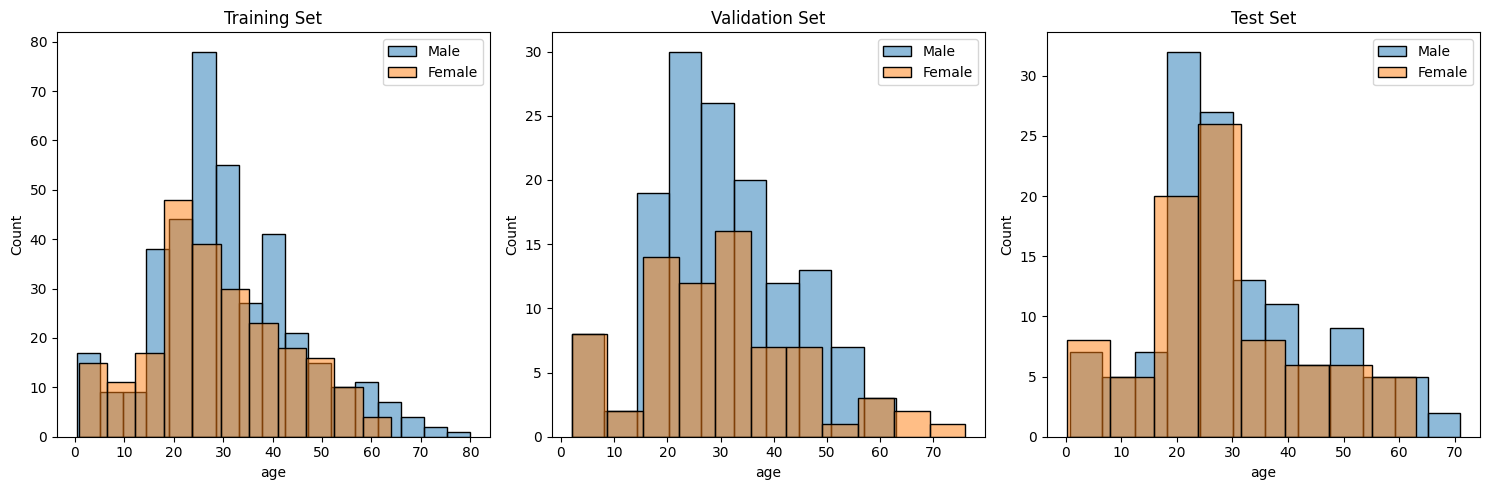

In [14]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Training set
males_train = X_train.loc[X_train['sex'] == 'male']
females_train = X_train.loc[X_train['sex'] == 'female']
sns.histplot(data=males_train, x='age', ax=ax1, label='Male', alpha=0.5)
sns.histplot(data=females_train, x='age', ax=ax1, label='Female', alpha=0.5)
ax1.set_title('Training Set')
ax1.legend()

# Validation set  
males_val = X_val.loc[X_val['sex'] == 'male']
females_val = X_val.loc[X_val['sex'] == 'female']
sns.histplot(data=males_val, x='age', ax=ax2, label='Male', alpha=0.5)
sns.histplot(data=females_val, x='age', ax=ax2, label='Female', alpha=0.5)
ax2.set_title('Validation Set')
ax2.legend()

# Test set
males_test = X_test.loc[X_test['sex'] == 'male']
females_test = X_test.loc[X_test['sex'] == 'female']
sns.histplot(data=males_test, x='age', ax=ax3, label='Male', alpha=0.5)
sns.histplot(data=females_test, x='age', ax=ax3, label='Female', alpha=0.5)
ax3.set_title('Test Set')
ax3.legend()

plt.tight_layout()

In [15]:
train_mean_by_gender = X_train.groupby('sex')['age'].mean()
X_train['age'] = X_train.groupby('sex')['age'].transform(
    lambda x: x.fillna(x.mean())
)

val_mean_by_gender = X_val.groupby('sex')['age'].mean()
X_val['age'] = X_val.groupby('sex')['age'].transform(
    lambda x: x.fillna(x.mean())
)

test_mean_by_gender = X_test.groupby('sex')['age'].mean()
X_test['age'] = X_test.groupby('sex')['age'].transform(
    lambda x: x.fillna(x.mean())
)

print(f"Training set: {X_train['age'].isnull().sum()}")
print(f"Validation set: {X_val['age'].isnull().sum()}")
print(f"Test set: {X_test['age'].isnull().sum()}")


Training set: 0
Validation set: 0
Test set: 0


### Fare missing values 

To deal with the fare, i compared the mean and the median. looking at the skewed distribution, the mean seems more appropriate.

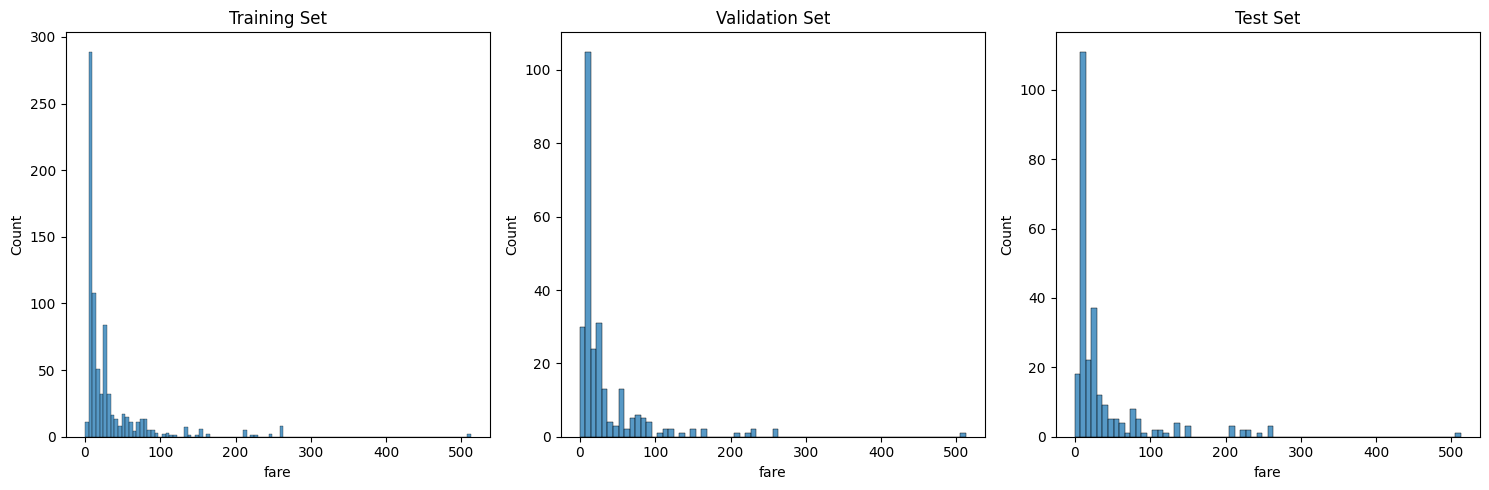

In [16]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot(X_train['fare'], ax=ax1)
ax1.set_title('Training Set')
sns.histplot(X_val['fare'], ax=ax2)
ax2.set_title('Validation Set') 
sns.histplot(X_test['fare'], ax=ax3)
ax3.set_title('Test Set')
plt.tight_layout()

In [17]:
train_fare_mean = X_train['fare'].mean()

X_train['fare'] = X_train['fare'].fillna(X_train['fare'].mean())
X_val['fare'] = X_val['fare'].fillna(X_train['fare'].mean())
X_test['fare'] = X_test['fare'].fillna(X_train['fare'].mean())

print(f"Training set: {X_train['fare'].isnull().sum()}")
print(f"Validation set: {X_val['fare'].isnull().sum()}")
print(f"Test set: {X_test['fare'].isnull().sum()}")

Training set: 0
Validation set: 0
Test set: 0


### Embarked missing values 

I dealt with the missing values in embarked by replacing them with the mode.

In [18]:
X_train['embarked'] = X_train['embarked'].fillna(X_train['embarked'].mode()[0])
X_val['embarked'] = X_val['embarked'].fillna(X_val['embarked'].mode()[0])
X_test['embarked'] = X_test['embarked'].fillna(X_test['embarked'].mode()[0])


print(f"Training set: {X_train['embarked'].isnull().sum()}")
print(f"Validation set: {X_val['embarked'].isnull().sum()}")
print(f"Test set: {X_test['embarked'].isnull().sum()}")

Training set: 0
Validation set: 0
Test set: 0


UPDATE: I went back to look at boxplots and identify outliers to improve the model's performance. I made sure to do it after splitting the data and handling missing values but before feature scaling and balancing the classes
- outliers can skew the scaling parameters
- ADASYN could introduce artificial outliers if they were kept. the synthetic samples should be created based on clean data to ensure they represent valid patterns.

To deal with outlierr, I chose clipping over removal to preserve data while minimizing extreme influences

I ended up getting rid of 'fare' outliers, the distribution showed extreme values that could disproportionately influence the model. it ended up improving my model.


In [19]:
Q1 = X_train['fare'].quantile(0.25)
Q3 = X_train['fare'].quantile(0.75)
IQR = Q3 - Q1
X_train['fare'] = X_train['fare'].clip(
    lower=Q1 - 1.5*IQR,
    upper=Q3 + 1.5*IQR
)

X_val['fare'] = X_val['fare'].clip(
    lower=Q1 - 1.5*IQR,
    upper=Q3 + 1.5*IQR
)

X_test['fare'] = X_test['fare'].clip(
    lower=Q1 - 1.5*IQR,
    upper=Q3 + 1.5*IQR
)

## Task 3: Encoding Categorical Variables

Only very few ML algorithms support categorical attributes, this is why encoding is crucial.

In my implementation, I used One-hot encoding after splitting because when we fit the encoder on training data only, we ensure that we're not using information from the test/validation sets. If it was done before, it could also lead to data leakage about category distributions from the test set to the training process.

In my case, each category recieved equal weights. The binary features are easily interpretable which will improve the ML algorithm's performance. 

In [20]:
X_train.head()

,pclass,name,sex,age,sibsp,parch,ticket,fare,embarked,home.dest,deck
382,2,"Corey, Mrs. Percy C (Mary Phyllis Elizabeth Mi...",female,28.575397,0,0,F.C.C. 13534,21.0000,S,"Upper Burma, India Pittsburgh, PA",U
356,2,"Butler, Mr. Reginald Fenton",male,25.000000,0,0,234686,13.0000,S,"Southsea, Hants",U
303,1,"Warren, Mr. Frank Manley",male,64.000000,1,0,110813,64.8958,C,"Portland, OR",D
646,3,"Asplund, Mrs. Carl Oscar (Selma Augusta Emilia...",female,38.000000,1,5,347077,31.3875,S,"Sweden Worcester, MA",U
309,1,"Wick, Miss. Mary Natalie",female,31.000000,0,2,36928,64.8958,S,"Youngstown, OH",C


We can see that the categorical variables are name, sex, ticket, embarked, home.dest and deck.

### Name and Home.dest encoding

We cant use name nor home.dest because encoding increases the dimensionality and sparsity. In high-dimensional spaces, data points become sparse. This means that the average distance between points increases, making it difficult to find meaningful patterns or clusters. Moreover, models tend to overfit the training data with high dimensionality. I dropped these columns.

In [21]:
X_train.drop(columns = ['name', 'home.dest'], inplace = True)
X_val.drop(columns = ['name', 'home.dest'], inplace = True)
X_test.drop(columns = ['name', 'home.dest'], inplace = True)

X_train.head()

,pclass,sex,age,sibsp,parch,ticket,fare,embarked,deck
382,2,female,28.575397,0,0,F.C.C. 13534,21.0000,S,U
356,2,male,25.000000,0,0,234686,13.0000,S,U
303,1,male,64.000000,1,0,110813,64.8958,C,D
646,3,female,38.000000,1,5,347077,31.3875,S,U
309,1,female,31.000000,0,2,36928,64.8958,S,C


### Sex, Embarked and Deck encoding

First, im encoding sex, embarked and deck using one-hot encoding (transforms a categorical attribute into several binary ones).

I also used drop='first' to drop the first column. This is to avoid multicollinearity with redundant features.

##### sex encoding:

- before: 2 categories (male, female)

- after : sex_male

##### embarked encoding:

- before: 3 categories (S,C,Q)

- after: embarked_S, embarked_Q


##### deck encoding:

- before: 9 categories (A,B,C,D,E,F,G,U)

- after: one column per deck except A

I created many sparse columns due to 'U' being dominant (1014 out of 1309 entries). This caused high dimensionality so I will need to fix it with feature selection in the next steps.

In [22]:
# Training set
encoder = OneHotEncoder(sparse_output=False, drop='first')
categorical_features = ['sex', 'embarked', 'deck']
encoded_features = encoder.fit_transform(X_train[categorical_features])
feature_names = encoder.get_feature_names_out(categorical_features)
encoded_df = pd.DataFrame(encoded_features, columns=feature_names, index=X_train.index)
X_train = pd.concat([X_train, encoded_df], axis=1)
X_train.drop(columns=categorical_features, inplace=True)

# Validation set
encoded_features = encoder.transform(X_val[categorical_features])
encoded_df = pd.DataFrame(encoded_features, columns=feature_names, index=X_val.index)
X_val = pd.concat([X_val, encoded_df], axis=1)
X_val.drop(columns=categorical_features, inplace=True)

# Test set 
encoded_features = encoder.transform(X_test[categorical_features])
encoded_df = pd.DataFrame(encoded_features, columns=feature_names, index=X_test.index)
X_test = pd.concat([X_test, encoded_df], axis=1)
X_test.drop(columns=categorical_features, inplace=True)

X_train.head()

,pclass,age,sibsp,parch,ticket,fare,sex_male,embarked_Q,embarked_S,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G,deck_T,deck_U
382,2,28.575397,0,0,F.C.C. 13534,21.0000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
356,2,25.000000,0,0,234686,13.0000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
303,1,64.000000,1,0,110813,64.8958,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
646,3,38.000000,1,5,347077,31.3875,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
309,1,31.000000,0,2,36928,64.8958,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Ticket encoding

I first assumed that ticket was similar to the family features sibsp and parch. However, friends couldve been included in the same ticket so I ended up creating ticket_group_size to have some insight about the size of the group travelling together.

We can see in the graph below that bigger groups had a better chance of survival. However, groups that were too big were also disadvantaged.

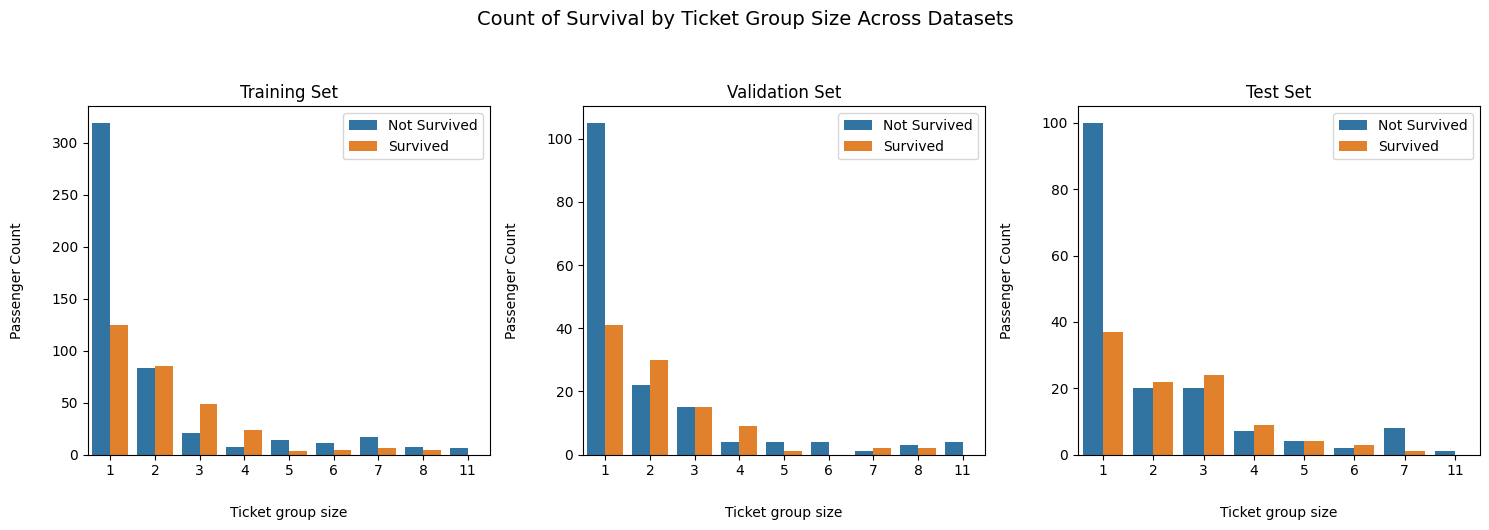

In [23]:
X_train['ticket_group_size'] = df.groupby('ticket')['ticket'].transform('count')[X_train.index]
X_val['ticket_group_size'] = df.groupby('ticket')['ticket'].transform('count')[X_val.index] 
X_test['ticket_group_size'] = df.groupby('ticket')['ticket'].transform('count')[X_test.index]

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# Training set 
sns.countplot(x='ticket_group_size', hue='survived', data=pd.concat([X_train, y_train], axis=1), ax=ax1)
ax1.set_xlabel('Ticket group size', size=10, labelpad=20)
ax1.set_ylabel('Passenger Count', size=10, labelpad=20)
ax1.tick_params(axis='x', labelsize=10)
ax1.tick_params(axis='y', labelsize=10)
ax1.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 10})
ax1.set_title('Training Set', size=12)

# Validation set 
sns.countplot(x='ticket_group_size', hue='survived', data=pd.concat([X_val, y_val], axis=1), ax=ax2)
ax2.set_xlabel('Ticket group size', size=10, labelpad=20)
ax2.set_ylabel('Passenger Count', size=10, labelpad=20)
ax2.tick_params(axis='x', labelsize=10)
ax2.tick_params(axis='y', labelsize=10)
ax2.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 10})
ax2.set_title('Validation Set', size=12)

# Test set 
sns.countplot(x='ticket_group_size', hue='survived', data=pd.concat([X_test, y_test], axis=1), ax=ax3)
ax3.set_xlabel('Ticket group size', size=10, labelpad=20)
ax3.set_ylabel('Passenger Count', size=10, labelpad=20)
ax3.tick_params(axis='x', labelsize=10)
ax3.tick_params(axis='y', labelsize=10)
ax3.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 10})
ax3.set_title('Test Set', size=12)

plt.suptitle('Count of Survival by Ticket Group Size Across Datasets', size=14, y=1.05)
plt.tight_layout()
plt.show()

In [24]:
X_train.drop('ticket', axis=1, inplace=True)
X_val.drop('ticket', axis=1, inplace=True) 
X_test.drop('ticket', axis=1, inplace=True)

X_train.head()

,pclass,age,sibsp,parch,fare,sex_male,embarked_Q,embarked_S,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G,deck_T,deck_U,ticket_group_size
382,2,28.575397,0,0,21.0000,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,2
356,2,25.000000,0,0,13.0000,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1
303,1,64.000000,1,0,64.8958,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,2
646,3,38.000000,1,5,31.3875,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,7
309,1,31.000000,0,2,64.8958,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,3


## Task 4: Feature Scaling


Multiple experiments demonstrated that learning algorithms applied to scaled features might produce a better model.

- Normalization: scales features to a predefined range of values ( ex:  [0,1] ). it is more sensitive to outliers but better for bounded data.

- Standardization: centers data around 0 with std = 1. the feature values have the properties of a standard normal distribution. It is more robust to outliers and better for unbounded data.

Feature scaling is important because it prevents features with larger numerical ranges from dominating the model's learning process. It makes sure that all the features contribute proportionally to the predictions.

If i did feature scaling before splitting, some statistics from the test/validation sets could leak into the scaling parameters (like mean and standard deviation). This violates the principle that test data should remain completely unseen during the model training process. This is why it should be done after splitting.

Based on the histograms, pclass, sibsp, parch and ticket_group_size all contain discrete values so should be normalized.

On the other hand, age and fare are continuous, they should be standarized.

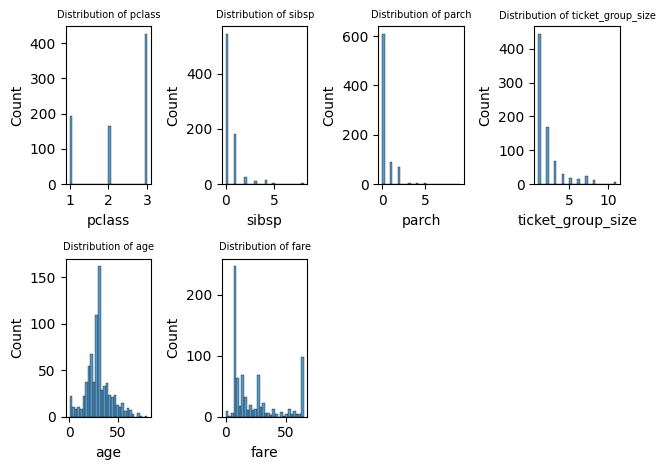

In [25]:
numeric_cols = ['pclass', 'sibsp', 'parch', 'ticket_group_size', 'age', 'fare']

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 4, i)
    sns.histplot(data=X_train, x=col, bins=30)
    plt.title(f'Distribution of {col}', fontsize=7)
    plt.xlabel(col)
    plt.ylabel('Count')

plt.tight_layout()
plt.show()

I used fit_transform() on the training data only so it learns the scaling parameters and apply them. We only fit on training data to avoid data leakage for validation/test sets.

transform() was used on validation/test sets since it only applies the scaling parameters learned from the training data.

In [26]:
# Normalize discrete features
normalizer = MinMaxScaler()
normalize_cols = ['pclass', 'sibsp', 'parch', 'ticket_group_size']
X_train[normalize_cols] = normalizer.fit_transform(X_train[normalize_cols])
X_val[normalize_cols] = normalizer.transform(X_val[normalize_cols])
X_test[normalize_cols] = normalizer.transform(X_test[normalize_cols])

# Standardize continuous features 
standardizer = StandardScaler()
standardize_cols = ['age', 'fare']
X_train[standardize_cols] = standardizer.fit_transform(X_train[standardize_cols])
X_val[standardize_cols] = standardizer.transform(X_val[standardize_cols])
X_test[standardize_cols] = standardizer.transform(X_test[standardize_cols])

X_train.head()

,pclass,age,sibsp,parch,fare,sex_male,embarked_Q,embarked_S,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G,deck_T,deck_U,ticket_group_size
382,0.5,-0.111622,0.000,0.000000,-0.133887,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.1
356,0.5,-0.389418,0.000,0.000000,-0.531163,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
303,0.0,2.640742,0.125,0.000000,2.045953,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.1
646,1.0,0.620635,0.125,0.555556,0.381950,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.6
309,0.0,0.076761,0.000,0.222222,2.045953,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2


## Task 6: Addressing Class Imbalance

Class imbalance is the problem of very uneven distributions of labels in the training data. This can significantly affect the performance of the model no matter what learning algorithm we chose. This is why we need to make sure that we have similar numbers of survived vs not survived.

Based on the target distribution in each set, we have more not survived than survived ( 60-40 ). however, we can use a sampling technique to reach 50-50.

We must choose oversampling over undersampling since our dataset is small.

Unlike random oversampling, ADASYN creates synthetic examples for the minority class rather than duplicating existing ones. 

I chose ADASYN over SMOTE for the Titanic dataset because survival patterns vary across different passenger groups. Those examples are in regions where minority class samples are harder to classify (close to the majority class samples). This will improves learning for the survived minority class samples.

I also made sure to apply ADASYN on the train set only because test and validation sets should reflect the natural and imbalanced distribution in the real world.

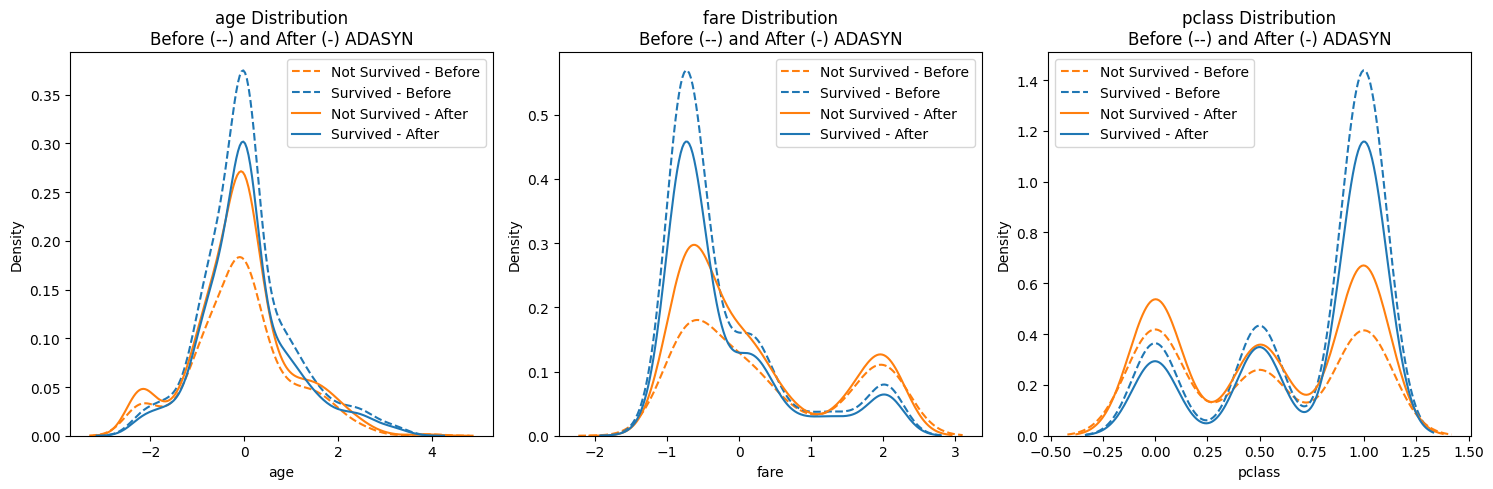

In [27]:
ada = ADASYN(random_state=42)
X_train_balanced, y_train_balanced = ada.fit_resample(X_train, y_train)

features_to_plot = ['age', 'fare', 'pclass']
fig, axes = plt.subplots(1, len(features_to_plot), figsize=(15, 5))

for i, feature in enumerate(features_to_plot):
    sns.kdeplot(data=X_train, x=feature, hue=y_train, 
                ax=axes[i], linestyle='--', label=['Not Survived', 'Survived'])
    
    sns.kdeplot(data=X_train_balanced, x=feature, hue=y_train_balanced, 
                ax=axes[i], linestyle='-')
    
    axes[i].set_title(f'{feature} Distribution\nBefore (--) and After (-) ADASYN')
    axes[i].legend(['Not Survived - Before', 'Survived - Before',
                   'Not Survived - After', 'Survived - After'])

plt.tight_layout()
plt.show()


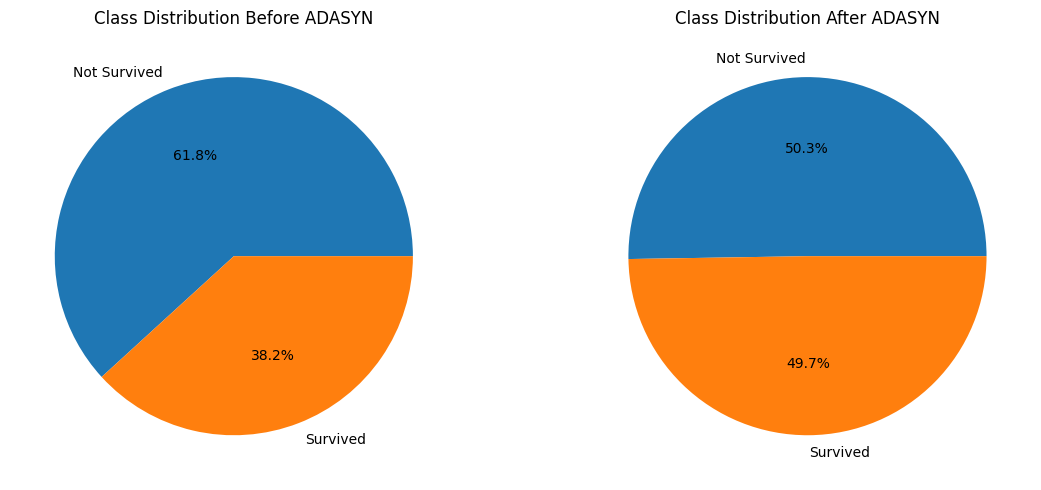

Before ADASYN: survived
0    0.617834
1    0.382166
Name: proportion, dtype: float64
After ADASYN: survived
1    0.502564
0    0.497436
Name: proportion, dtype: float64


In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

before_values = y_train.value_counts(normalize=True)
ax1.pie(before_values, labels=['Not Survived', 'Survived'], autopct='%1.1f%%')
ax1.set_title('Class Distribution Before ADASYN')

after_values = y_train_balanced.value_counts(normalize=True)
ax2.pie(after_values, labels=['Not Survived', 'Survived'], autopct='%1.1f%%')
ax2.set_title('Class Distribution After ADASYN')

plt.tight_layout()
plt.show()

print("Before ADASYN:", before_values)
print("After ADASYN:", after_values)

We can see that ADASYN successfully balanced the classes while preserving the patterns in the data. The original distributions were maintained.

## Task 7: Feature Selection

Not all features are equally relevant. My first step was to look at low variance and highly correlated features

In [29]:
X_train_balanced.head()

,pclass,age,sibsp,parch,fare,sex_male,embarked_Q,embarked_S,deck_B,deck_C,deck_D,deck_E,deck_F,deck_G,deck_T,deck_U,ticket_group_size
0,0.5,-0.111622,0.000,0.000000,-0.133887,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.1
1,0.5,-0.389418,0.000,0.000000,-0.531163,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,2.640742,0.125,0.000000,2.045953,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.1
3,1.0,0.620635,0.125,0.555556,0.381950,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.6
4,0.0,0.076761,0.000,0.222222,2.045953,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2


In [30]:
selector = VarianceThreshold(threshold=0.01)
selector.fit(X_train_balanced)
low_variance_features = X_train_balanced.columns[~selector.get_support()].tolist()

print("Low variance features:")
for feature in low_variance_features:
    print(f"- {feature} (variance: {X_train_balanced[feature].var():.4f})")

correlation_matrix = X_train_balanced.corr()
high_correlation_pairs = []
correlation_threshold = 0.8

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
            high_correlation_pairs.append(
                (correlation_matrix.columns[i], 
                 correlation_matrix.columns[j], 
                 correlation_matrix.iloc[i, j])
            )

print("\nHighly correlated feature pairs:")
for feat1, feat2, corr in high_correlation_pairs:
    print(f"- {feat1} & {feat2}: {corr:.4f}")

Low variance features:
- parch (variance: 0.0090)
- deck_F (variance: 0.0073)
- deck_G (variance: 0.0040)
- deck_T (variance: 0.0010)

Highly correlated feature pairs:


In addition, implementing Boruta might be more beneficial to have a better understanding of the important features. It could be more reliable than the single-pass feature selection done above.

(Especially that survival has non-linear relationships with the features)

In [31]:
rf = RandomForestClassifier(n_jobs=-1, random_state=42) # random forest is the base estimator

boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42)

boruta.fit(X_train_balanced.values, y_train_balanced)

selected_features = X_train_balanced.columns[boruta.support_]
    
feature_ranks = pd.DataFrame({
    'Feature': X_train_balanced.columns,
    'Rank': boruta.ranking_,
    'Important': boruta.support_
})

feature_ranks.sort_values('Rank')

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	17
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	3
Tentative: 	0
Rejected: 	14


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	3
Tentative: 	0
Rejected: 	14


,Feature,Rank,Important
1,age,1,True
5,sex_male,1,True
4,fare,1,True
16,ticket_group_size,2,False
0,pclass,3,False
2,sibsp,3,False
3,parch,5,False
7,embarked_S,6,False
15,deck_U,7,False
6,embarked_Q,8,False


Looking at the Boruta results:

Age, sex_male and fare are the strongest predictor of survival.

Family features such as sibsp parch and ticket_group_size arent marked as important. this could mean that family size wasnt a primar survival factor.

Location features such as embarked_ and deck_ ranked lowest which could mean that placement had minimal impact on survival. 

UPDATE: after testing the model, i decided to include ticket_group_size.


In [32]:
selected_features = ['age', 'sex_male', 'fare', 'ticket_group_size']
X_train_selected = X_train_balanced[selected_features]
print(selected_features)

['age', 'sex_male', 'fare', 'ticket_group_size']


The main reason why we addressed class imbalance and feature selection after splitting the dataset is to prevent data leakage.

- If we applied ADASYN before splitting, synthetic samples would leak into test/validation sets. Therefore, the test set wouldnt represent real-world data distribution.


- If we applied Boruta before splitting, the different importances of the features would be influenced by the test data which can lead to selection bias.

(We must always remember that all the transformations should be learned from the training data only)

## Task 8: Training a Logistic Regression Model

In [33]:
X_train_selected.shape
y_train_balanced.shape

(975,)

In [34]:
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train_selected, y_train_balanced)

y_pred = lr_model.predict(X_val[selected_features])
y_pred_proba = lr_model.predict_proba(X_val[selected_features])

y_test_pred = lr_model.predict(X_test[selected_features])
y_test_pred_proba = lr_model.predict_proba(X_test[selected_features])


After experimenting for a while with my model, i went back and made some additional changes (such as removing fare outliers and adding more selected features). Although the series of decisions I had to make lead to some trade-offs, I believe I ended up with a more reliable and consistent model.

Here are the final analytics of the model's performance:

Text(158.22222222222223, 0.5, 'Actual')

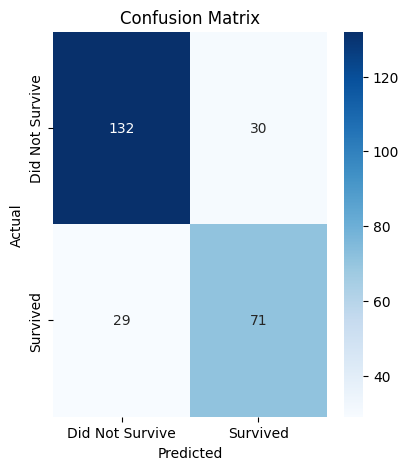

In [35]:
plt.figure(figsize=(15, 5))

plt.subplot(131)
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Did Not Survive', 'Survived'],
            yticklabels=['Did Not Survive', 'Survived'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

Text(158.22222222222223, 0.5, 'Actual')

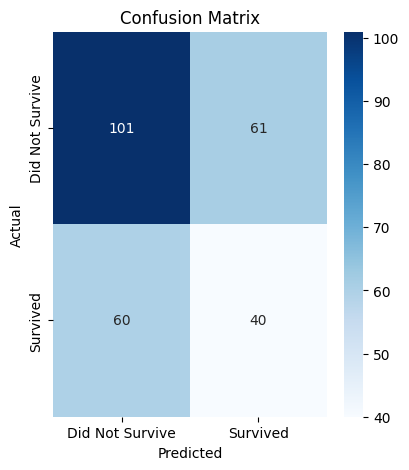

In [36]:
plt.figure(figsize=(15, 5))

plt.subplot(131)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Did Not Survive', 'Survived'],
            yticklabels=['Did Not Survive', 'Survived'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')

In [37]:
print(classification_report(y_val, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.81      0.82       162
           1       0.70      0.71      0.71       100

    accuracy                           0.77       262
   macro avg       0.76      0.76      0.76       262
weighted avg       0.78      0.77      0.78       262



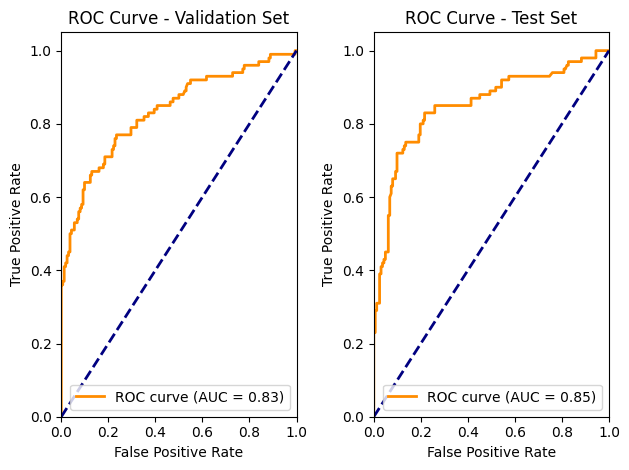

In [38]:
plt.subplot(121)
fpr_val, tpr_val, _ = roc_curve(y_val, y_pred_proba[:, 1])
roc_auc_val = auc(fpr_val, tpr_val)
plt.plot(fpr_val, tpr_val, color='darkorange', lw=2,
         label=f'ROC curve (AUC = {roc_auc_val:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Validation Set')
plt.legend(loc="lower right")

plt.subplot(122)
fpr_test, tpr_test, _ = roc_curve(y_test, y_test_pred_proba[:, 1])
roc_auc_test = auc(fpr_test, tpr_test)
plt.plot(fpr_test, tpr_test, color='darkorange', lw=2,
         label=f'ROC curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Test Set')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

Looking at the ROC curve for the validation and test set, here are some key take-outs:

AUC of 0.83-0.85 indicates good model performance. there is an 85% chance that the model will rank a randomly chosen positive (survivor) higher than a randomly chosen negative (non-survivor)

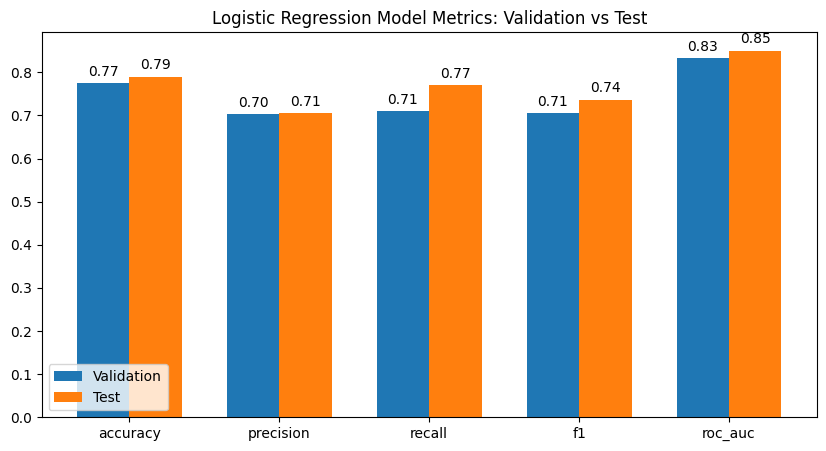

In [39]:
y_test_pred = lr_model.predict(X_test[selected_features])
y_test_pred_proba = lr_model.predict_proba(X_test[selected_features])

val_metrics = {
    "accuracy": accuracy_score(y_val, y_pred),
    "precision": precision_score(y_val, y_pred),
    "recall": recall_score(y_val, y_pred),
    "f1": f1_score(y_val, y_pred),
    "roc_auc": roc_auc_score(y_val, y_pred_proba[:, 1])
}

test_metrics = {
    "accuracy": accuracy_score(y_test, y_test_pred),
    "precision": precision_score(y_test, y_test_pred),
    "recall": recall_score(y_test, y_test_pred),
    "f1": f1_score(y_test, y_test_pred),
    "roc_auc": roc_auc_score(y_test, y_test_pred_proba[:, 1])
}

metrics = ['accuracy', 'precision', 'recall', 'f1', 'roc_auc']
val_values = [val_metrics[metric] for metric in metrics]
test_values = [test_metrics[metric] for metric in metrics]

x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 5))
rects1 = ax.bar(x - width/2, val_values, width, label='Validation')
rects2 = ax.bar(x + width/2, test_values, width, label='Test')

ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.set_title("Logistic Regression Model Metrics: Validation vs Test")
ax.legend()

def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

plt.show()

The visualisation of the logistic regression model shows that the model's performance is consistent across validation and test sets which means good generalization. 
- accuracy = TP+TN/total = 77-79% -> the model correctly predicted ~79% of the 262 cases. this shows good predictive power.

- recall = TP/TP+FN = 71-77% -> out of all the survivors the model predicted ~77% corretly.

- precision = TP/TP+FP = 70-71% -> out of the predicted survivors ~71% actually survived



## Conclusion

This analysis of the Titanic dataset demonstrates a robust approach to binary classification. It achieved consistent and reliable performance metrics across validation and test sets.

I carefully structured the model development process to ensure reliable predictions:

1- Data Preprocessing:

- Handling missing values, differentiating between pre-split constants and post-split statistical imputations.
- Feature engineering, including the creation of derived features like ticket_group_size, deck_, etc.
- Outlier management through clipping rather than removal, preserving data while minimizing extreme influences.


2- Methodological Choices:

- ADASYN for class balancing because of its approach to synthetic sample generation.
- 60-20-20 split ratio to ensure robust validation and testing capabilities.
- Boruta algorithm for feature selection resulting in a clear set of predictive variables.

3- Model Performance:
- Accuracy of ~79% across test sets.
- ROC-AUC score of 0.85, indicating strong discriminative ability.
- Balanced precision (71%) and recall (77%) scores that show reliable predictions for both survival and non-survival cases


Looking at these results, I can say that the model captured key survival patterns while maintaining interpretability and avoiding overfitting.


Future improvements could focus on:
- Model selection and comparison
- hyperparameter optimization
- cross-validation strategies



